In [1]:
# standard libraries
import pandas as pd
import numpy as np
#import re
import os
from IPython.display import Image
#import sklearn
#import time

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate
from IPython.display import clear_output

# data pre-processing
from scipy.io import arff
#from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit

# prediction models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

In [2]:
os.getcwd()

'C:\\Users\\allep\\QTW_Projects\\QTW-SPRING-2022\\ds7333_case_study_4'

In [3]:
from os import listdir
from os.path import isfile, join
dir_files = [f for f in os.listdir(os.getcwd()+'/data') if os.path.isfile(join(os.getcwd()+'/data', f))]

dir_files

['1year.arff', '2year.arff', '3year.arff', '4year.arff', '5year.arff']

In [4]:
data_dict = {}
full_df = pd.DataFrame()

records = 0

for f in dir_files:
    temp_data = arff.loadarff(os.getcwd()+'/data/'+f)
    temp_df = pd.DataFrame(temp_data[0])
    print(temp_df.shape)
    data_dict.update({f:temp_df})
    full_df = pd.concat([full_df, temp_df])
    records += temp_df.shape[0]
    
print(records)

(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)
43405


In [5]:
full_df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5900, 5901, 5902, 5903, 5904, 5905, 5906, 5907, 5908, 5909],
           dtype='int64', length=43405)

In [6]:
full_df = full_df.reset_index(drop=True)
full_df.index

RangeIndex(start=0, stop=43405, step=1)

In [7]:
full_df.tail()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
43400,0.012898,0.70621,0.038857,1.17220,-18.907,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,b'1'
43401,-0.578050,0.96702,-0.800850,0.16576,-67.365,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,b'1'
43402,-0.179050,1.25530,-0.275990,0.74554,-120.440,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,b'1'
43403,-0.108860,0.74394,0.015449,1.08780,-17.003,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,b'1'
43404,-0.105370,0.53629,-0.045578,0.91478,-56.068,-0.10537,-0.109940,0.86460,0.95040,0.463670,...,-0.052186,-0.227250,1.05220,0.003196,7.7332,4.7174,136.850,2.6672,2.79270,b'1'


In [8]:
full_df['class'].value_counts()

b'0'    41314
b'1'     2091
Name: class, dtype: int64

In [9]:
full_df['class'].value_counts(normalize=True)

b'0'    0.951826
b'1'    0.048174
Name: class, dtype: float64

In [10]:
full_df['bankrupt'] = ( full_df['class'] == full_df['class'][full_df.shape[0]-1] ).astype(int)
full_df['bankrupt'].value_counts()

0    41314
1     2091
Name: bankrupt, dtype: int64

In [11]:
full_df = full_df.drop('class', axis=1)

### Drop Attr37 with 46% missing data?

In [12]:
missing = full_df.isnull().sum()
pct_missing = missing/missing.sum()*100
pct_missing.sort_values(ascending=False).head(15)

Attr37    45.941629
Attr21    14.166788
Attr27     6.688931
Attr60     5.207880
Attr45     5.195779
Attr24     2.231257
Attr64     1.965055
Attr53     1.965055
Attr28     1.965055
Attr54     1.965055
Attr41     1.824694
Attr32     0.890567
Attr52     0.728426
Attr47     0.718745
Attr46     0.326702
dtype: float64

In [13]:
missing_0 = full_df[full_df['bankrupt']==0].isnull().sum()
pct_missing_0 = missing_0/missing_0.sum()
missing_1 = full_df[full_df['bankrupt']==1].isnull().sum()
pct_missing_1 = missing_1/missing_1.sum()
pct_missing_by_bankruptcy = pd.concat([pct_missing_0, pct_missing_1], axis=1)
pct_missing_by_bankruptcy.columns = ['0','1']

### Attr27 has a lot more missing values for bankrupt=1 vs. bankrupt=0.  Impute as a different value for modeling?

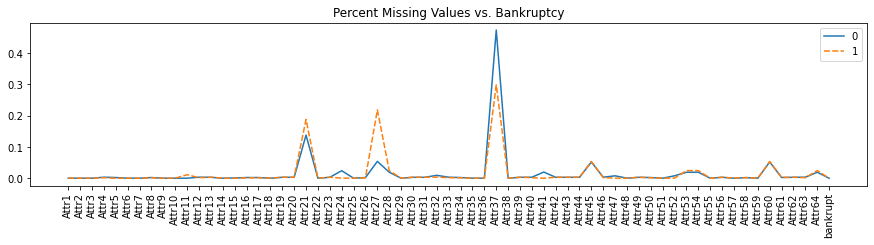

In [14]:
plt.figure(figsize=(15,3))
sns.lineplot(data = pct_missing_by_bankruptcy)
plt.xticks(rotation=90)
plt.title('Percent Missing Values vs. Bankruptcy')
plt.show()

In [15]:
def split_dependant_and_independant_variables(df: pd.DataFrame, y_var: str):
    X = df.copy()
    y = X[y_var]
    X = X.drop([y_var], axis=1)
    return X, y

In [16]:
X, y = split_dependant_and_independant_variables(full_df, 'bankrupt')

### Heatmap shows some strong positive and negative correlations between features

<AxesSubplot:>

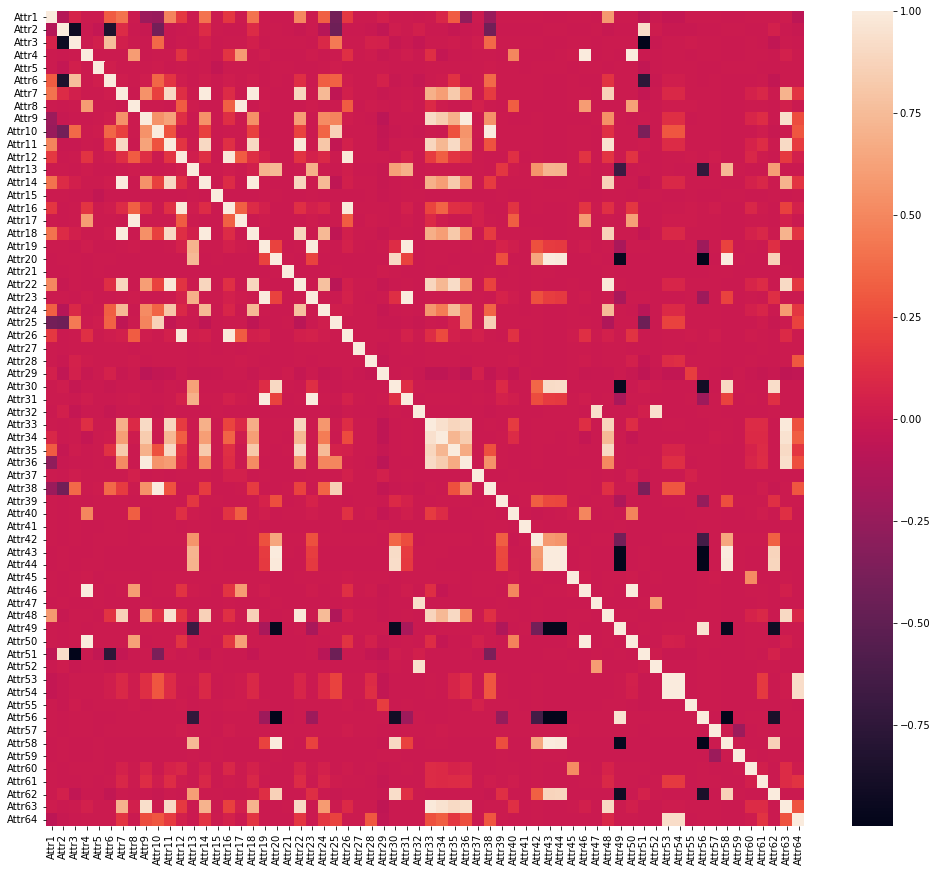

In [17]:
plt.figure(figsize=(17,15))
sns.heatmap(data=X.corr())

### Boxplots show features that are all highly zero-inflated, and many have extreme outliers

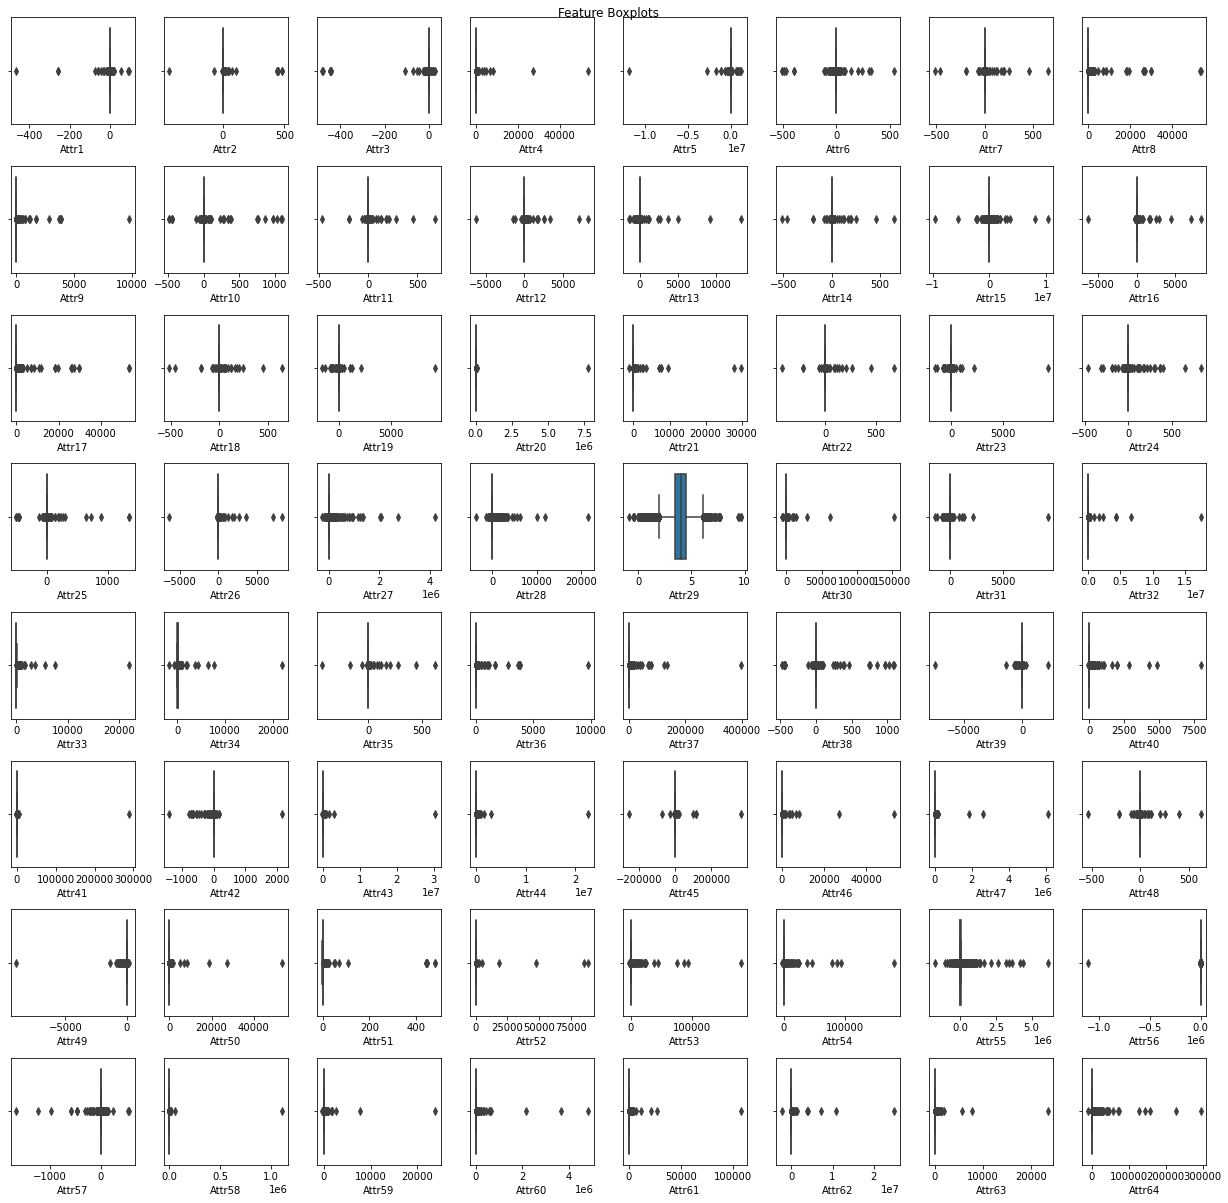

In [18]:
features = X.columns
fig, axes = plt.subplots(8, 8, figsize=(17, 17))
fig.suptitle('Feature Boxplots')
for i,j in zip(features, range(64)):
    sns.boxplot(ax = axes[int(j/8), j%8], x = full_df[i])

fig.tight_layout()

### Boxplots with biggest outliers removed

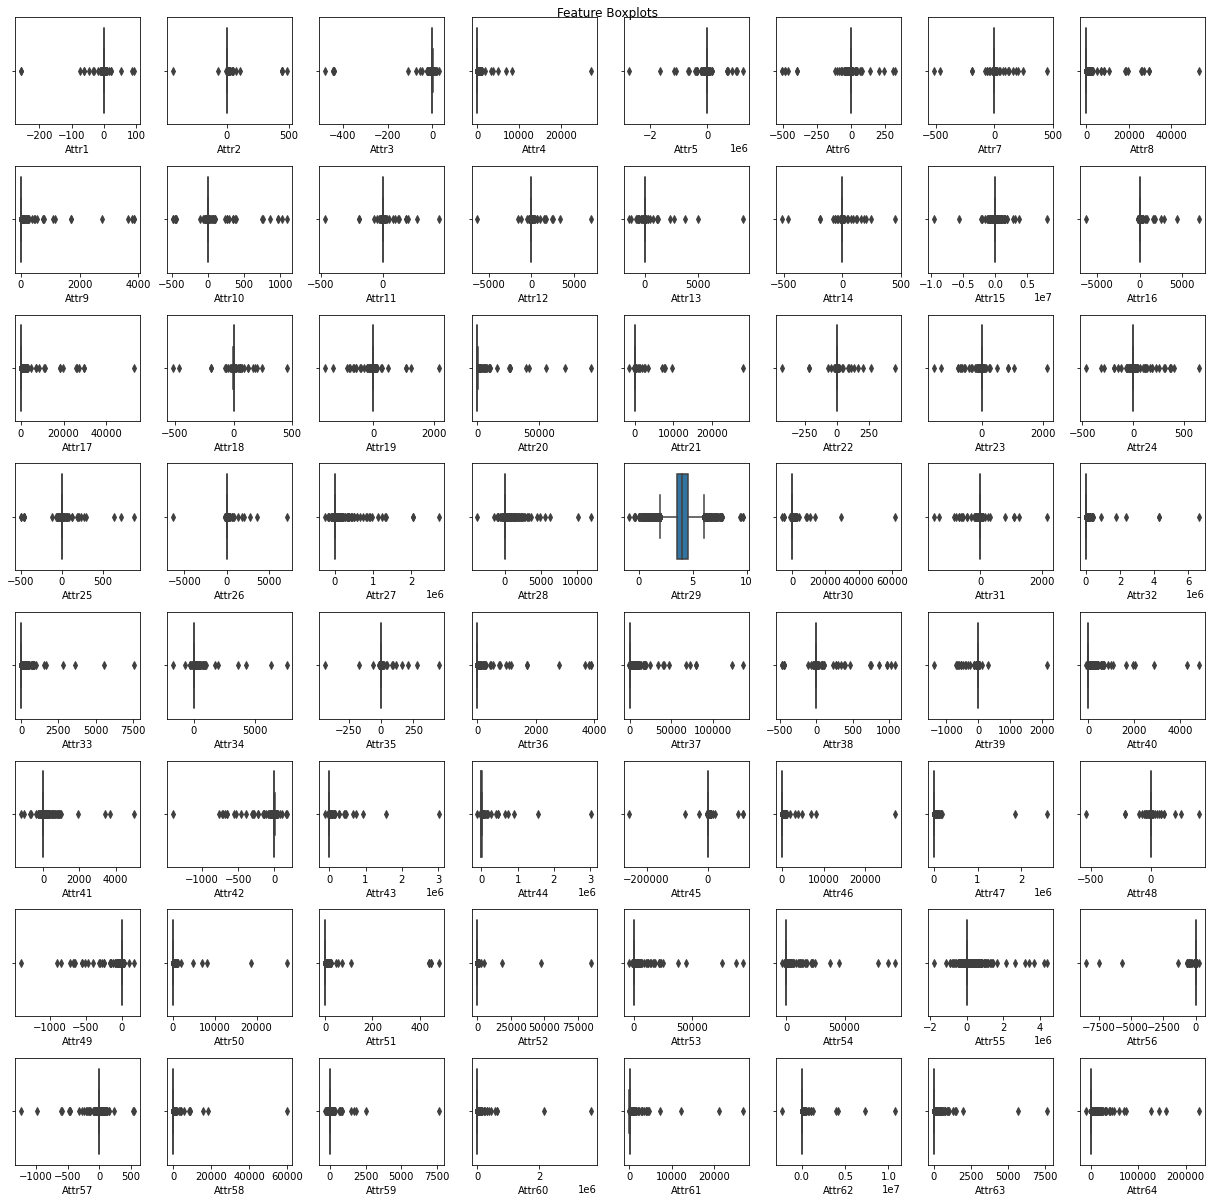

In [19]:
features = X.columns

fig, axes = plt.subplots(8, 8, figsize=(17, 17))
fig.suptitle('Feature Boxplots')
for i,j in zip(features, range(64)):
    sns.boxplot(ax = axes[int(j/8), j%8], 
                x = full_df[i][ abs(full_df[i]) < max( abs(full_df[i].min()), abs(full_df[i].max()) ) ] #remove outliers
                )

fig.tight_layout()

In [20]:
def strat_shuffle_split(X, y, test_size, random_state):
    stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in stratified_shuffle_split.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

In [21]:
X_train, X_test, y_train, y_test = strat_shuffle_split(X, y, test_size=0.3, random_state=12343)

In [22]:
# Use median imputation since many features are highly skewed

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(X_train)

X_train_imp = pd.DataFrame( imp_mean.transform(X_train), columns = X.columns, index = X_train.index )
X_test_imp = pd.DataFrame( imp_mean.transform(X_test), columns = X.columns, index = X_test.index )

### Baseline accuracy = 95.2%

In [23]:
y_train.value_counts(normalize=True)

0    0.951815
1    0.048185
Name: bankrupt, dtype: float64

In [24]:
y_test.value_counts(normalize=True)

0    0.951851
1    0.048149
Name: bankrupt, dtype: float64

In [25]:
def train_test_scores(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # fixed this
    
    y_hat_rf_train = model.predict(X_train) # fixed this
    y_hat_rf_test = model.predict(X_test) # fixed this
    
    train_acc = accuracy_score(y_train, y_hat_rf_train)
    test_acc = accuracy_score(y_test, y_hat_rf_test)
    
    train_f1 = f1_score(y_train, y_hat_rf_train)
    test_f1 = f1_score(y_test, y_hat_rf_test)
    
    scores = train_acc, test_acc, train_f1, test_f1
    new_row = {'max_depth': model.max_depth, 'train_acc': train_acc, 'test_acc': test_acc, 'train_f1': train_f1, 'test_f1': test_f1}
    return new_row

def get_results_df(model, X_train, X_test, y_train, y_test, df):
    new_row = train_test_scores(model, X_train, X_test, y_train, y_test) # fixed this
    df = df.append(new_row, ignore_index=True) 
    return df

### Not specifying max_depth causes overfitting and poor generalization 

In [26]:
rf_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
results = pd.DataFrame({'max_depth' : [], 'train_acc' : [], 'test_acc' : [], 'train_f1': [], 'test_f1' : []})

get_results_df(rf_clf, X_train_imp, X_test_imp, y_train, y_test, results)

,max_depth,train_acc,test_acc,train_f1,test_f1
0,NaN,0.999967,0.960989,0.999658,0.366584


### Decreasing max_depth reduces overfitting
Tried n_estimators as well, lower n_estimators decreased overall performance, larger n_estimators didn't really improve overall performance

In [27]:
results = pd.DataFrame({'max_depth' : [], 'train_acc' : [], 'test_acc' : [], 'train_f1': [], 'test_f1' : []})

for i in range(4,21):
    rf_clf_2 = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = i)
    results = get_results_df(rf_clf_2, X_train_imp, X_test_imp, y_train, y_test, results)
    print("max_depth =", i, "complete")

clear_output()
results

,max_depth,train_acc,test_acc,train_f1,test_f1
0,4.0,0.765988,0.755951,0.237942,0.222222
1,5.0,0.803443,0.790508,0.278221,0.253421
2,6.0,0.847086,0.830057,0.338365,0.288196
3,7.0,0.882763,0.861696,0.412599,0.318577
4,8.0,0.917059,0.895331,0.508963,0.373333
5,9.0,0.943027,0.918446,0.605425,0.404709
6,10.0,0.959286,0.933344,0.688177,0.431937
7,11.0,0.972847,0.943941,0.771784,0.447806
8,12.0,0.979857,0.950161,0.822196,0.459617
9,13.0,0.985288,0.953310,0.865402,0.454219


### max_depth>12 is where overfitting is egregious.  
### max_depth > 8 is where f1 starts to really diverge between train and test.  

<AxesSubplot:xlabel='max_depth'>

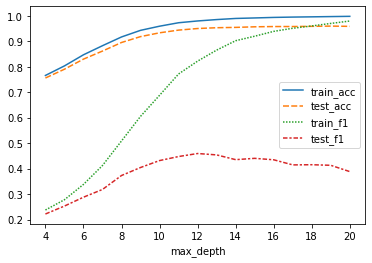

In [28]:
results_plot_df = results.copy()
results_plot_df.index = results_plot_df['max_depth'].astype(int)
results_plot_df = results_plot_df.drop('max_depth', axis=1)

sns.lineplot(data=results_plot_df)

### Nicer looking visual

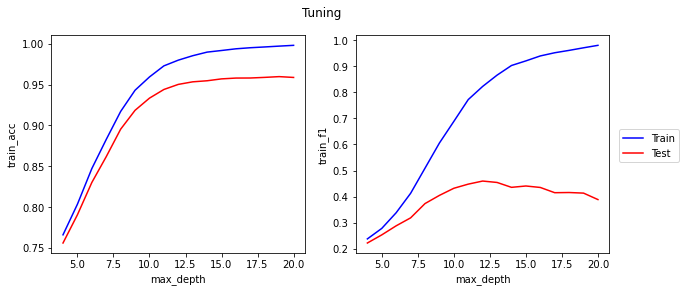

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Tuning')
sns.lineplot(ax=axes[0], data=results, x='max_depth', y='train_acc', color='blue')
sns.lineplot(ax=axes[0], data=results, x='max_depth', y='test_acc', color='red')

sns.lineplot(ax=axes[1], data=results, x='max_depth', y='train_f1', color='blue')
sns.lineplot(ax=axes[1], data=results, x='max_depth', y='test_f1', color='red')

fig.legend(['Train','Test'], loc='right')
plt.show()

### Assign a unique extreme value to missing values for non-linear random forest modeling
In this way, missing values get binned way out by themselves rather than binned with the median values.

Find the global min and max values for the training set (no data leakage) and set the missing value out 1000 times farther.

In [33]:
# find the global min and max values for all of the training predictors
train_global_min = X_train.min().min()
print("Train global min=", train_global_min)
train_global_max = X_train.max().max()
print("Train global max=", train_global_max)

Train global min= -11903000.0
Train global max= 30393000.0


In [34]:
imp_value_min = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=train_global_min*1000)
imp_value_min.fit(X_train)

X_train_imp_min = pd.DataFrame( imp_value_min.transform(X_train), columns = X.columns, index = X_train.index )
X_test_imp_min = pd.DataFrame( imp_value_min.transform(X_test), columns = X.columns, index = X_test.index )

### Improves Accuracy and F1 by 3-4%

In [35]:
results2 = pd.DataFrame({'max_depth' : [], 'train_acc' : [], 'test_acc' : [], 'train_f1': [], 'test_f1' : []})

for i in range(4,9):
    rf_clf_2 = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = i)
    results2 = get_results_df(rf_clf_2, X_train_imp_min, X_test_imp_min, y_train, y_test, results2)
    print("max_depth =", i, "complete")

clear_output()
results2

,max_depth,train_acc,test_acc,train_f1,test_f1
0,4.0,0.791331,0.784135,0.267898,0.254970
1,5.0,0.827173,0.815543,0.317254,0.287240
2,6.0,0.868249,0.852634,0.384059,0.326430
3,7.0,0.898628,0.879435,0.454674,0.361789
4,8.0,0.926373,0.906927,0.540374,0.408203


### Slight improvement using extreme max value vs. extreme min value
Could add complexity by using both min & max depending on the feature skewing + or - 

In [36]:
imp_value_max = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=train_global_max*1000)
imp_value_max.fit(X_train)

X_train_imp_max = pd.DataFrame( imp_value_max.transform(X_train), columns = X.columns, index = X_train.index )
X_test_imp_max = pd.DataFrame( imp_value_max.transform(X_test), columns = X.columns, index = X_test.index )

In [37]:
results3 = pd.DataFrame({'max_depth' : [], 'train_acc' : [], 'test_acc' : [], 'train_f1': [], 'test_f1' : []})

for i in range(4,9):
    rf_clf_2 = RandomForestClassifier(random_state=0, class_weight='balanced', max_depth = i)
    results3 = get_results_df(rf_clf_2, X_train_imp_max, X_test_imp_max, y_train, y_test, results3)
    print("max_depth =", i, "complete")

clear_output()
results3

,max_depth,train_acc,test_acc,train_f1,test_f1
0,4.0,0.792219,0.782599,0.271269,0.256760
1,5.0,0.823388,0.813777,0.308683,0.281481
2,6.0,0.865846,0.852327,0.378279,0.326445
3,7.0,0.897739,0.879358,0.450769,0.360081
4,8.0,0.927459,0.908386,0.541025,0.414909
